# Initial Imports & Setup

In [1]:
# Data Science Modules
import numpy as np
import pandas as pd
import altair as alt
from selenium import webdriver

# Python Modules
import glob as glob
import os
import datetime as datetime

%load_ext blackcellmagic

# Lookup Data

* **./files/names.csv**: CSV File with Provider/Clinic Names, etc. Names is used to determine active providers/clinics. (So if there's no name, it wont get evaluated later -- say, for example, after Everson Closes.)
* **./files/metrics.csv**: CSV File with Metrics information (Display Name, Category, Target, etc.)

In [2]:
# Read Lookup files into dataframes for mapping
names = pd.read_csv("./files/names.csv", index_col="MeridiosName")
metrics = pd.read_csv(
    "./files/metrics.csv", index_col="MeridiosMetric", dtype={"MeridiosMetric": object}
)


# Import Data from /data folder.

This makes a dataframe in a 'Tidy Data' format.

* **./data/(Zero-Padded Date at beginning of CSVs from Meridos).csv**: Files from Automatic weekly report from Meridios

In [4]:
# The base dataframe, df, get's transformed into different data subsets.
df = pd.DataFrame()

# Read in all the data files and append to dataframe
files = glob.glob("./data/*.csv")
for file in files:
    filedf = pd.read_csv(file, usecols=["NAME", "Metricname", "SeenNum", "SeenDenom"])
    # Prettier Names but we'll drop these eventually.
    filedf = filedf.rename(
        columns={
            "NAME": "MeridiosName",
            "Metricname": "MeridiosMetric",
            "SeenNum": "Numerator",
            "SeenDenom": "Denominator",
        }
    )

    # Add Lookup Columns.
    filedf["Name"] = filedf.MeridiosName.map(names.Name)
    filedf["Type"] = filedf.MeridiosName.map(names.Type)
    filedf["Clinic"] = filedf.MeridiosName.map(names.Clinic)
    filedf["Metric"] = filedf.MeridiosMetric.map(metrics.Metric)

    # Who are we kidding with precision? Round to Basis points
    # Not actually percentage (but rather than * 100 leaving for formatting
    # in visualization.)
    filedf["Percentage"] = round(filedf["Numerator"] / filedf["Denominator"], 4)

    # Zero Padded Dates with Dots. Like: "03.15.2018" We're using the filename
    # as the source of the date column because Meridios exports haven't always
    # had the date-time data correct.
    filename_parts = file[7:-4].split(" ")
    if len(str(filename_parts[0])) is 10:
        filedf["Date"] = datetime.datetime.strptime(filename_parts[0], "%m.%d.%Y")

        # Now delete the 'raw' columns from import so dataframe is smaller.
        filedf.drop(
            ["MeridiosName", "MeridiosMetric", "Numerator", "Denominator"],
            axis=1,
            inplace=True,
        )
        df = df.append(filedf)
    else:
        # We're only appending data that had Zero Padded Date at
        # beginning of filename.
        print("CSV Data File doesn't have Zero-Padded Date at beginning.")


# Dataframe Review

The dataframe is the dataset for all the various graphs. We can inspect it various ways, if needed. (Used for development, not really validation.)

In [55]:
# df.dtypes
# df.info()
# df.describe()
# df.columns
# df.Metric.unique()
# df.head()
# metrics.head()

## Validations:

* Do new CSV files include new MeridiosName, New Metric items? (Has the underlying report changed? Such as when edited provider name.)
* Should we keep a list of already imported data and do some message to clarify after new data is available?
* Percentages under 0% and over 100% are report errors

Currently no validations. But probably should automate checks that new data from report is accurate. 

# Make Individual Graphs

make_individual_metric_chart makes a layered chart with the individuals recent progress, their clinic's progress, and how it's currently distributed in FCN. Assumes that dataframes names & metrics exists.

In [8]:
def make_individual_metric_chart(metric, name):
    # Data Transformations in Pandas for graphs.
    # assumes dataframe 'df' that has data from CSVs
    # assumes dataframes 'names' and 'metrics' for lookups
    
    
    providerdf = df[
        (df["Metric"] == metric) & (df["Type"] == "Individual") & (df["Name"] == name)
    ]

    # Lookup clinic from the provider name in the names dataframe. 
    # Make a comparison dataframe.
    clinic_name = names[names.Name == name].iloc[0].Clinic
    clinicdf = df[(df["Metric"] == metric) & (df["Name"] == clinic_name)]
    
    # Lookup the metric target -- not all metrics have a target. 
    try:
        metric_target = metrics[metrics.Metric == metric].iloc[0].Target
    except:
        metric_target = False

    # If there's a target value, we'll make a rule on graph.
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    # Make a Current dataframe to use for Strip Chart. 
    current_date = max(df["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Individual")
        & (df["Date"] == current_date)
    ]

    # Altair Graphs to combine.
    provider_progress_line = (
        alt.Chart(providerdf)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.Color("Name:N", legend=None),
        )
        .properties(width=200, height=200)
    )

    # 1f77b4 -- blue, #ff7f0e -- orange. Currently hardcoded but eventually
    # will look up a clinic color. Also will be used in the HTML generation. 

    clinic_progress_line = (
        alt.Chart(clinicdf)
        .mark_line(strokeWidth=2)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#ff7f0e"),
        )
    )

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4,2])
            .encode(
                y="TargetValue:Q", color=alt.value("green"), opacity=alt.value("0.5")
            )
        )

    fcn_current_strip_chart = (
        alt.Chart(current_metric)
        .mark_tick(color="#eee")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title="", labels=False),
                scale=alt.Scale(domain=(0, 1)),
            )
        )
        .properties(height=200)
    )

    provider_highlight_strip = (
        alt.Chart(current_metric)
        .mark_tick()
        .encode(alt.Y("Percentage:Q"), opacity=alt.value("1.0"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=name))
    )

    provider_percent = (
        provider_highlight_strip.mark_text(
            align="left", baseline="middle", dx=15, size=20
        )
        .encode(text=alt.Text("Percentage:Q", format=".2%"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=name))
    )

    if metric_target:
        chart = provider_progress_line + clinic_progress_line + metric_target_rule | (
            fcn_current_strip_chart + provider_highlight_strip + provider_percent
        )
        return chart
    else:
        chart = provider_progress_line + clinic_progress_line | (
            fcn_current_strip_chart + provider_highlight_strip + provider_percent
        )
        return chart

# Prepping for the chart generation

* We're only looking at single providers (not clinics)
* We're only doing some of the available metrics 
* Need the Current Date so pages can have that info.

In [10]:
# Need to just do active individuals, main metrics
singleprovider = names[(names["Type"] == "Individual")]
main_metrics = [
    "AAA",
    "Chlamydia",
    "Colorectal Screen",
    "DM with Statin",
    "DM with ACE or ARB",
    "DM Eye Exam",
    "DM Foot Exam",
    "Mammogram",
    "DM Nephropathy",
    "Pap Smears",
    "DM Pneumovax",
    "Over age 65 Pneumovax",
    "Smoker Pneumovax",
    "TD and TDAP",
]

current_date = str(max(df["Date"]))

# Single Provider Pages

This generates the graphs and makes the associated pages for single providers.

In [9]:
for name in singleprovider.Name.unique():
    for metric in df.Metric.unique():
        if metric in main_metrics:
            chart = make_individual_metric_chart(metric, name)
            foldername = str(name).replace(" ", "_")
            if not os.path.exists("./docs/" + foldername):
                os.makedirs("./docs/" + foldername)
            chart.save(
                "./docs/" + foldername + "/" + str(metric).replace(" ", "_") + ".png"
            )

    provider_dropdown = (
        '<div class="uk-inline"><div class="uk-text-lead" style="color:#1f77b4">'
        + name
        + '<span uk-icon="icon: triangle-down"></span>'
        + '</div><div uk-dropdown><ul class="uk-nav uk-dropdown-nav">'
    )

    clinic_name = names[names.Name == name].iloc[0].Clinic

    for sameclinicprovider in sorted(
        set(singleprovider[singleprovider.Clinic == clinic_name].Name)
    ):
        if name == sameclinicprovider:
            provider_dropdown += (
                '<li class="uk-active">'
                + sameclinicprovider
                + '<span uk-icon="icon: check"></span></li>\n'
            )
        else:
            provider_dropdown += (
                '<li><a href="../'
                + str(sameclinicprovider).replace(" ", "_")
                + '/">'
                + sameclinicprovider
                + "</a></li>\n"
            )

    # close provider_dropdown
    provider_dropdown += "</ul></div></div>"

    with open("./files/index.html", "r") as file:
        filedata = file.read()
    filedata = filedata.replace("{{{Provider}}}", provider_dropdown)
    filedata = filedata.replace("{{{Clinic}}}", clinic_name)
    filedata = filedata.replace("{{{Current Date}}}", current_date)
    with open("./docs/" + foldername + "/index.html", "w+") as file:
        file.write(filedata)


CannotSendRequest: Request-sent

In [24]:
def make_clinic_metric_chart(metric, clinic_name):
    # Data Transformations in Pandas for graphs.
    # assumes dataframe 'df' that has data from CSVs
    # assumes dataframes 'names' and 'metrics' for lookups
    providerdf = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Clinic")
        & (df["Name"] == clinic_name)
    ]

    try:
        metric_target = metrics[metrics.Metric == metric].iloc[0].Target
    except:
        metric_target = False

    # If there's a target value, we'll make a rule on graph.
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    current_date = max(df["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Clinic")
        & (df["Date"] == current_date)
    ]

    # Altair Graphs to combine.
    clinic_progress_line = (
        alt.Chart(providerdf)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.Color("Name:N", legend=None),
        )
        .properties(width=200, height=200)
    )

    # 1f77b4 -- blue, #ff7f0e -- orange

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1)
            .encode(
                y="TargetValue:Q", color=alt.value("green"), opacity=alt.value("0.5")
            )
        )

    fcn_current_strip_chart = (
        alt.Chart(current_metric)
        .mark_tick(color="#eee")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title="", labels=False),
                scale=alt.Scale(domain=(0, 1)),
            )
        )
        .properties(height=200)
    )

    provider_highlight_strip = (
        alt.Chart(current_metric)
        .mark_tick()
        .encode(alt.Y("Percentage:Q"), opacity=alt.value("1.0"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=clinic_name))
    )

    provider_percent = (
        provider_highlight_strip.mark_text(
            align="left", baseline="middle", dx=15, size=20
        )
        .encode(text=alt.Text("Percentage:Q", format=".2%"))
        .transform_filter(alt.FieldEqualPredicate(field="Name", equal=clinic_name))
    )

    clinic_providers = sorted(
        set(singleprovider[singleprovider.Clinic == clinic_name].Name)
    )
    current_date = max(df["Date"])
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == current_date)
        & (df["Name"].isin(clinic_providers))
    ]

    start_date = min(df["Date"])
    start_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == start_date)
        & (df["Name"].isin(clinic_providers))
    ]
    start_and_current = pd.concat([start_metric, current_metric])

    ranged_dot = (
        alt.Chart(start_and_current)
        .mark_line(color="#db646f")
        .encode(
            alt.X("Percentage:Q", axis=alt.Axis(format="%", title="")),
            alt.Y("Name:N", axis=alt.Axis(title="")),
            detail="Name:N",
        )
        .properties(width=300)
    )

    ranged_dot += (
        alt.Chart(current_metric)
        .mark_point(size=100, opacity=1, filled=True, color="#911a24")
        .encode(x="Percentage:Q", y="Name:N")
    )

    if metric_target:
        chart = (
            clinic_progress_line + metric_target_rule + provider_percent
        ) | ranged_dot
        return chart
    else:
        chart = (clinic_progress_line + provider_percent) | ranged_dot
        return chart


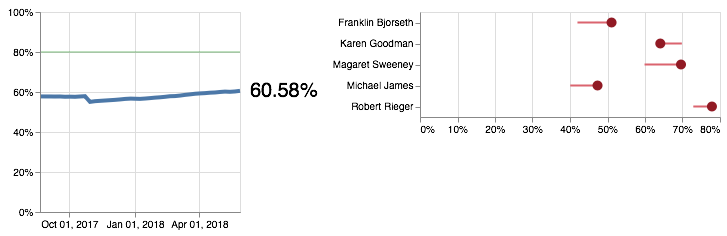

In [29]:
metric = 'TD and TDAP'
clinic_name = 'IFP'
chart = make_clinic_metric_chart(metric, clinic_name)
chart

In [15]:
def clinic_ranged_dot(metric, clinic_name):
    providerdf = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Individual")
        & (df["Name"] == clinic_name)
    ]

    
    )
    #chart += (
    #    alt.Chart(start_metric)
    #    .mark_point(size=100, opacity=1, filled=True, color="#e6959c")
    #    .encode(x="Percentage:Q", y="Name:N")
    #)
    return chart

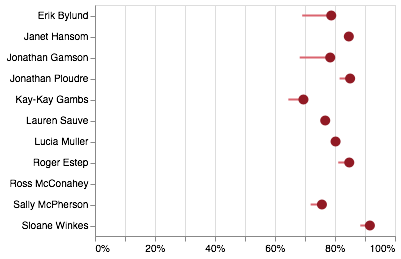